# Fiesole

This project aims to demonstrate the feasibility of Vertical-Federated-Learning CNN architectures.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [2]:
BATCH_SIZE = 32
MNIST_CLASSES = 10
LEARNING_RATE = 0.001
ALL_HANDS_ON_DECK = 50
AMBIENT = 0.0001


In [3]:
class QuadrantTransform:
    def __init__(self, quadrant):
        assert quadrant in [
            "tl",
            "tr",
            "bl",
            "br",
        ], "Invalid quadrant. Choose from 'tl', 'tr', 'bl', 'br'"
        self.quadrant = quadrant

    def __call__(self, img):
        # Convert PIL image to tensor
        tensor = transforms.ToTensor()(img)

        # Create a blank (transparent) tensor of the same shape
        blank = torch.zeros_like(tensor)

        # Generate ambient noise
        noise = torch.rand(tensor.shape) * AMBIENT

        if self.quadrant == "tl":
            blank[:, :14, :14] = tensor[:, :14, :14]
            blank[:, :14, 14:] = noise[:, :14, 14:]
            blank[:, 14:, :14] = noise[:, 14:, :14]
            blank[:, 14:, 14:] = noise[:, 14:, 14:]
        elif self.quadrant == "tr":
            blank[:, :14, 14:] = tensor[:, :14, 14:]
            blank[:, :14, :14] = noise[:, :14, :14]
            blank[:, 14:, 14:] = noise[:, 14:, 14:]
            blank[:, 14:, :14] = noise[:, 14:, :14]
        elif self.quadrant == "bl":
            blank[:, 14:, :14] = tensor[:, 14:, :14]
            blank[:, :14, :14] = noise[:, :14, :14]
            blank[:, 14:, 14:] = noise[:, 14:, 14:]
            blank[:, :14, 14:] = noise[:, :14, 14:]
        elif self.quadrant == "br":
            blank[:, 14:, 14:] = tensor[:, 14:, 14:]
            blank[:, :14, 14:] = noise[:, :14, 14:]
            blank[:, 14:, :14] = noise[:, 14:, :14]
            blank[:, :14, :14] = noise[:, :14, :14]

        return blank


In [4]:
transform_tl = transforms.Compose([QuadrantTransform("tl")])
transform_tr = transforms.Compose([QuadrantTransform("tr")])
transform_bl = transforms.Compose([QuadrantTransform("bl")])
transform_br = transforms.Compose([QuadrantTransform("br")])

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

trainset_tl = torchvision.datasets.MNIST(
    root="./control", train=True, download=True, transform=transform_tl
)
trainset_tr = torchvision.datasets.MNIST(
    root="./control", train=True, download=True, transform=transform_tr
)
trainset_bl = torchvision.datasets.MNIST(
    root="./control", train=True, download=True, transform=transform_bl
)
trainset_br = torchvision.datasets.MNIST(
    root="./control", train=True, download=True, transform=transform_br
)

trainloader_tl = torch.utils.data.DataLoader(trainset_tl, batch_size=4)
trainloader_tr = torch.utils.data.DataLoader(trainset_tr, batch_size=4)
trainloader_bl = torch.utils.data.DataLoader(trainset_bl, batch_size=4)
trainloader_br = torch.utils.data.DataLoader(trainset_br, batch_size=4)


testset = torchvision.datasets.MNIST(
    root="./control", train=False, download=True, transform=transform
)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)


In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc_relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = x.view(-1, 64 * 7 * 7)

        x = self.fc1(x)
        x = self.fc_relu1(x)
        x = self.fc2(x)
        return x


In [6]:
model = CNN()

if torch.cuda.is_available():
    model = model.cuda()

criterion = nn.CrossEntropyLoss()


In [7]:
import matplotlib.pyplot as plt


def visualize_mnist_digit_horizontally(digits):
    fig, axs = plt.subplots(1, len(digits))
    for i, digit in enumerate(digits):
        if digit.shape != (28, 28):
            digit = digit.reshape(28, 28)
        axs[i].imshow(digit, cmap="gray")
        axs[i].axis("off")  # hide the axis
    plt.show()


def example(trainset_tl, trainset_tr, trainset_bl, trainset_br):
    data_idx = torch.randint(0, len(trainset_tl), (1,)).item()

    digits = [
        trainset_tl[data_idx][0],
        trainset_tr[data_idx][0],
        trainset_bl[data_idx][0],
        trainset_br[data_idx][0],
    ]

    visualize_mnist_digit_horizontally(digits)
    print(trainset_tl[data_idx][1])


In [8]:
def test_model(debug_string, model):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(debug_string, correct / total)
    return correct / total


# Training loop
def train_model(model, trainloader, optimizer):
    num_epochs = 1
    model.train()
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(trainloader):
            if torch.cuda.is_available():
                model = model.cuda()
                images = images.cuda()
                labels = labels.cuda()
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


def average_weights(*models):
    """Averages the weights of the given models."""
    avg_dict = {}

    # Get the state dictionary of the first model to initialize the avg_dict
    for key in models[0].state_dict().keys():
        avg_dict[key] = sum([model.state_dict()[key] for model in models]) / len(models)

    return avg_dict


In [9]:
import copy

tl_history = []
tr_history = []
bl_history = []
br_history = []
avg_history = []


def federated_learning(original_model):
    model_tl = copy.deepcopy(original_model)
    optimizer_tl = optim.Adam(model_tl.parameters(), lr=LEARNING_RATE)
    model_tr = copy.deepcopy(original_model)
    optimizer_tr = optim.Adam(model_tr.parameters(), lr=LEARNING_RATE)
    model_bl = copy.deepcopy(original_model)
    optimizer_bl = optim.Adam(model_bl.parameters(), lr=LEARNING_RATE)
    model_br = copy.deepcopy(original_model)
    optimizer_br = optim.Adam(model_br.parameters(), lr=LEARNING_RATE)

    transform_tl = transforms.Compose([QuadrantTransform("tl")])
    transform_tr = transforms.Compose([QuadrantTransform("tr")])
    transform_bl = transforms.Compose([QuadrantTransform("bl")])
    transform_br = transforms.Compose([QuadrantTransform("br")])

    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    )

    trainset_tl = torchvision.datasets.MNIST(
        root="./control", train=True, download=True, transform=transform_tl
    )
    trainset_tr = torchvision.datasets.MNIST(
        root="./control", train=True, download=True, transform=transform_tr
    )
    trainset_bl = torchvision.datasets.MNIST(
        root="./control", train=True, download=True, transform=transform_bl
    )
    trainset_br = torchvision.datasets.MNIST(
        root="./control", train=True, download=True, transform=transform_br
    )

    trainloader_tl = torch.utils.data.DataLoader(trainset_tl, batch_size=4)
    trainloader_tr = torch.utils.data.DataLoader(trainset_tr, batch_size=4)
    trainloader_bl = torch.utils.data.DataLoader(trainset_bl, batch_size=4)
    trainloader_br = torch.utils.data.DataLoader(trainset_br, batch_size=4)

    example(trainset_tl, trainset_tr, trainset_bl, trainset_br)

    train_model(model_tl, trainloader_tl, optimizer_tl)
    tl_history.append(test_model("TL", model_tl))

    train_model(model_tr, trainloader_tr, optimizer_tr)
    tr_history.append(test_model("TR", model_tr))

    train_model(model_bl, trainloader_bl, optimizer_bl)
    bl_history.append(test_model("BL", model_bl))

    train_model(model_br, trainloader_br, optimizer_br)
    br_history.append(test_model("BR", model_br))

    avg_state_dict = average_weights(model_tl, model_tr, model_bl, model_br)

    new_model = CNN()
    new_model.load_state_dict(avg_state_dict)

    if torch.cuda.is_available():
        new_model = new_model.cuda()

    avg_history.append(test_model("avg", new_model))
    return new_model


Iteration 1


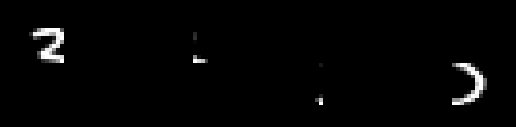

3
TL 0.1232
TR 0.1686
BL 0.1031
BR 0.0892
avg 0.1414
Iteration 2


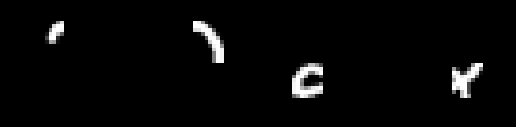

2
TL 0.1135
TR 0.1667
BL 0.1044
BR 0.0952
avg 0.1401
Iteration 3


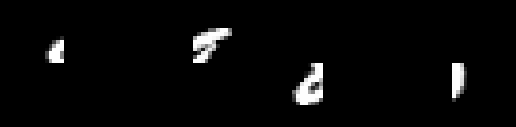

8
TL 0.1259
TR 0.1105
BL 0.1323
BR 0.0892
avg 0.1425
Iteration 4


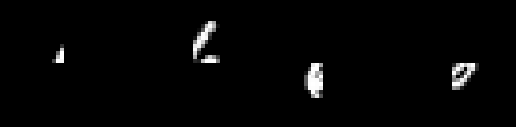

6
TL 0.0803
TR 0.0983
BL 0.2069
BR 0.0892
avg 0.1414
Iteration 5


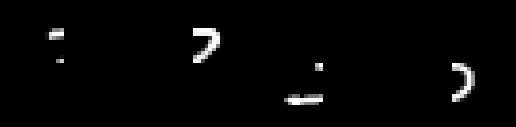

3
TL 0.1042
TR 0.1284
BL 0.3886
BR 0.0892
avg 0.115
Iteration 6


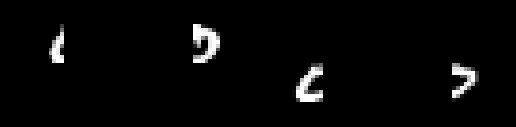

8
TL 0.107
TR 0.1157
BL 0.3216
BR 0.0892
avg 0.0964
Iteration 7


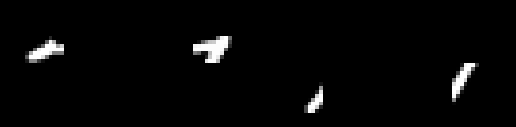

7
TL 0.1033
TR 0.1513
BL 0.1857
BR 0.0892
avg 0.0962
Iteration 8


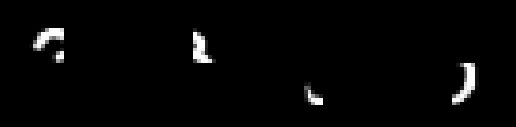

3
TL 0.1032
TR 0.159
BL 0.13
BR 0.0882
avg 0.1019
Iteration 9


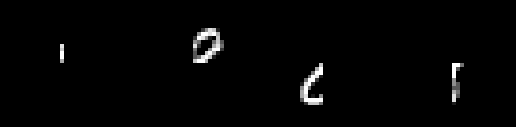

8
TL 0.1037
TR 0.1357
BL 0.1829
BR 0.0936
avg 0.0797
Iteration 10


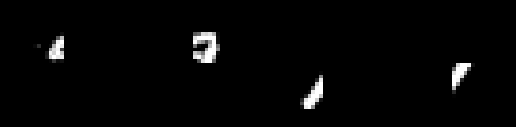

9
TL 0.1132
TR 0.1674
BL 0.1863
BR 0.0892
avg 0.0807
Iteration 11


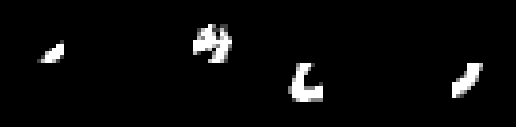

0
TL 0.1095
TR 0.1737
BL 0.186
BR 0.0858
avg 0.0862
Iteration 12


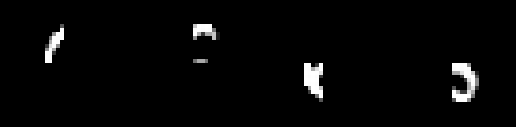

6
TL 0.1032
TR 0.1558
BL 0.1788
BR 0.0892
avg 0.1081
Iteration 13


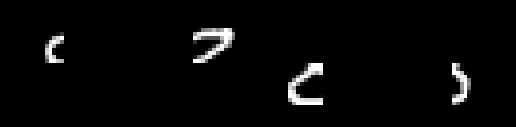

8
TL 0.1033
TR 0.1569
BL 0.1566
BR 0.0892
avg 0.1032
Iteration 14


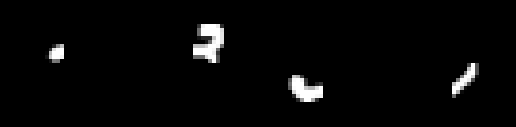

3
TL 0.1032
TR 0.1032
BL 0.1206
BR 0.0892
avg 0.1032
Iteration 15


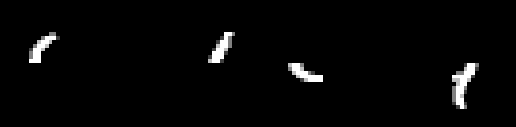

4
TL 0.1032
TR 0.1032
BL 0.1502
BR 0.0986
avg 0.1032
Iteration 16


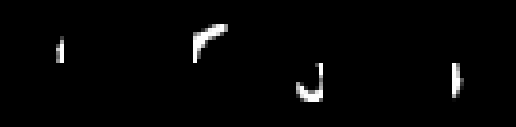

5
TL 0.1032
TR 0.1032
BL 0.1645
BR 0.1791
avg 0.1032
Iteration 17


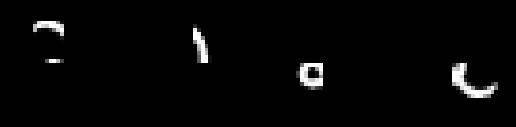

2
TL 0.1032
TR 0.1032
BL 0.1053
BR 0.0905
avg 0.1032
Iteration 18


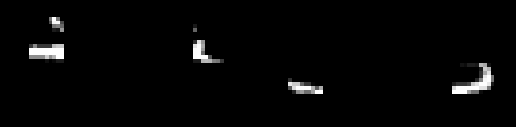

3
TL 0.1032
TR 0.1032
BL 0.1805
BR 0.1972
avg 0.1032
Iteration 19


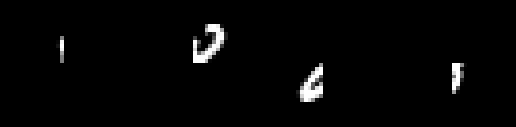

8
TL 0.1032
TR 0.1032
BL 0.1761
BR 0.1127
avg 0.1032
Iteration 20


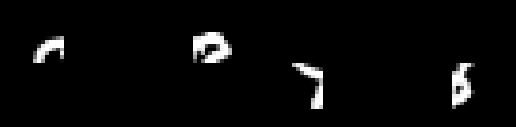

8
TL 0.1032
TR 0.1032
BL 0.1128
BR 0.1825
avg 0.1032
Iteration 21


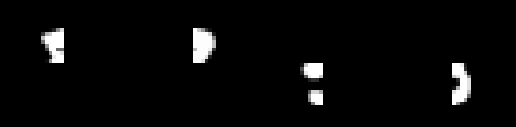

3
TL 0.1032
TR 0.1032
BL 0.1041
BR 0.1663
avg 0.1032
Iteration 22


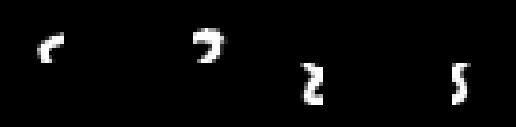

8
TL 0.1032
TR 0.1032
BL 0.1032
BR 0.1044
avg 0.1032
Iteration 23


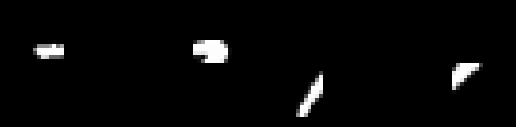

7
TL 0.1032
TR 0.1032
BL 0.1636
BR 0.1058
avg 0.1032
Iteration 24


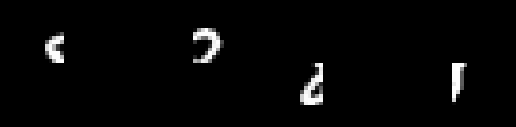

8
TL 0.1032
TR 0.1032
BL 0.1033
BR 0.115
avg 0.1032
Iteration 25


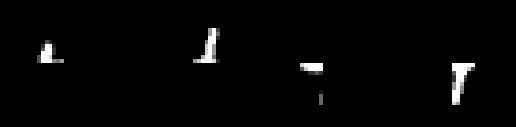

4
TL 0.1032
TR 0.1032
BL 0.1149
BR 0.1029
avg 0.1032
Iteration 26


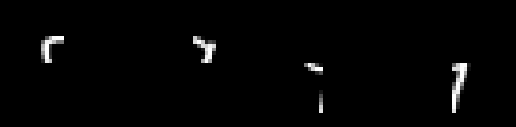

9
TL 0.1032
TR 0.1032
BL 0.1219
BR 0.1028
avg 0.1032
Iteration 27


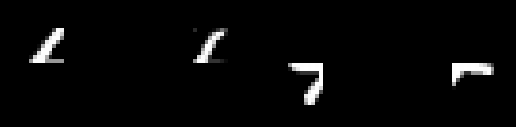

4
TL 0.1032
TR 0.1032
BL 0.1199
BR 0.1028
avg 0.1032
Iteration 28


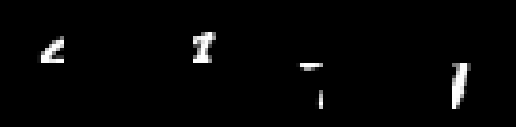

9
TL 0.1032
TR 0.1032
BL 0.1271
BR 0.1028
avg 0.1032
Iteration 29


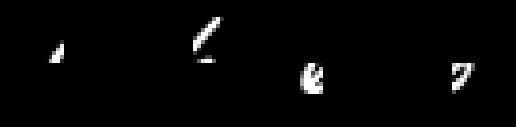

6
TL 0.1032
TR 0.1032
BL 0.1649
BR 0.1028
avg 0.1032
Iteration 30


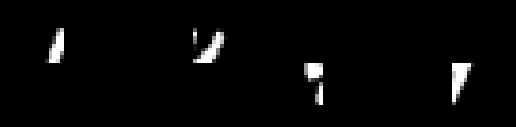

4
TL 0.1032
TR 0.1032
BL 0.1032
BR 0.1028
avg 0.1032
Iteration 31


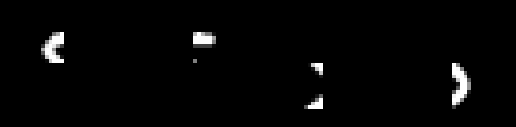

5
TL 0.1032
TR 0.1032
BL 0.114
BR 0.1028
avg 0.1032
Iteration 32


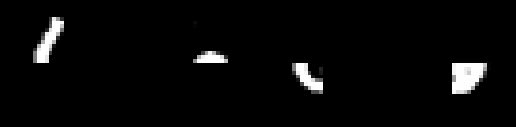

6
TL 0.1032
TR 0.1032
BL 0.1034
BR 0.1118
avg 0.1032
Iteration 33


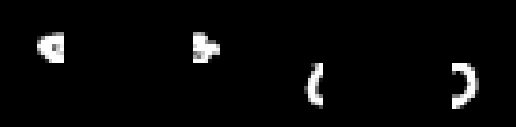

8
TL 0.1032
TR 0.1032
BL 0.1032
BR 0.103
avg 0.1032
Iteration 34


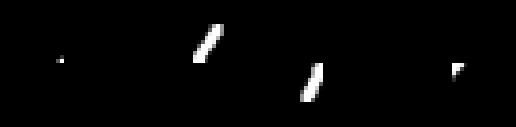

1
TL 0.1032
TR 0.1032
BL 0.1032
BR 0.1034
avg 0.1032
Iteration 35


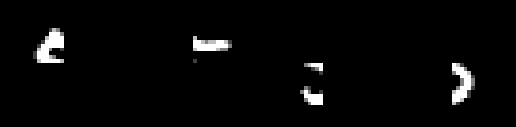

5
TL 0.1032
TR 0.1032
BL 0.1032
BR 0.1028
avg 0.1032
Iteration 36


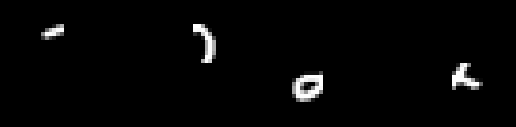

2
TL 0.1032
TR 0.1032
BL 0.1032
BR 0.1276
avg 0.1032
Iteration 37


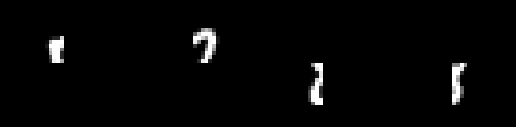

8
TL 0.1032
TR 0.1032
BL 0.1032
BR 0.1028
avg 0.1032
Iteration 38


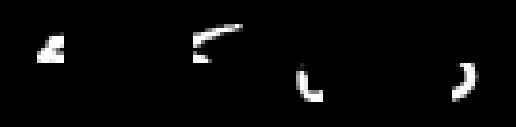

5
TL 0.1032
TR 0.1032
BL 0.1032
BR 0.1028
avg 0.1032
Iteration 39


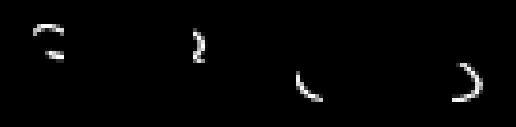

3
TL 0.1032
TR 0.1032
BL 0.1032
BR 0.1028
avg 0.1032
Iteration 40


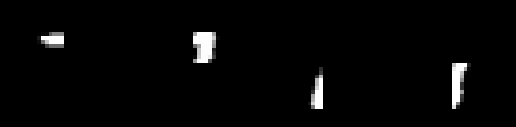

7
TL 0.1032
TR 0.1032
BL 0.1032
BR 0.1032
avg 0.1032
Iteration 41


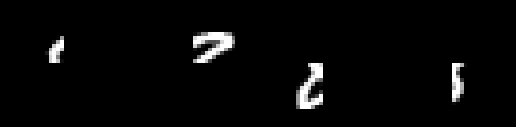

8
TL 0.1032
TR 0.1032
BL 0.1032
BR 0.1028
avg 0.1032
Iteration 42


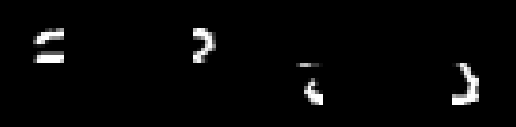

3
TL 0.1032
TR 0.1032
BL 0.1032
BR 0.1028
avg 0.1032
Iteration 43


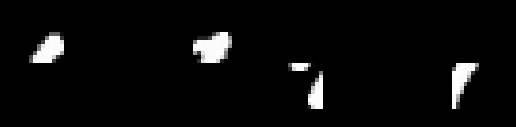

7
TL 0.1032
TR 0.1032
BL 0.1032
BR 0.1207
avg 0.1032
Iteration 44


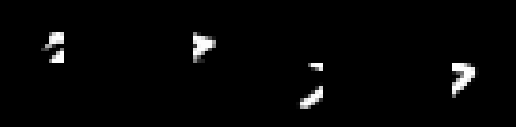

3
TL 0.1032
TR 0.1032
BL 0.1032
BR 0.1028
avg 0.1032
Iteration 45


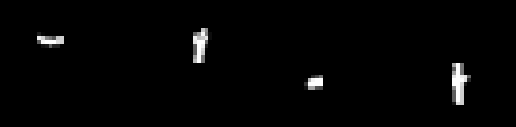

7
TL 0.1032
TR 0.1032
BL 0.1032
BR 0.1028
avg 0.1032
Iteration 46


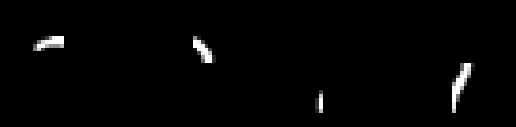

7
TL 0.1032
TR 0.1032
BL 0.1032
BR 0.1038
avg 0.1032
Iteration 47


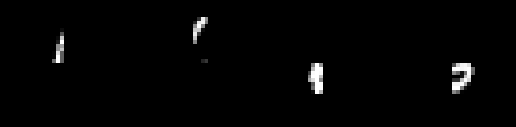

6
TL 0.1032
TR 0.1032
BL 0.1032
BR 0.1028
avg 0.1032
Iteration 48


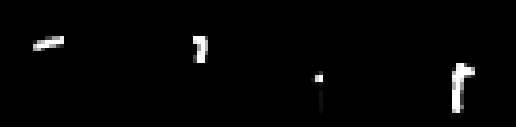

7
TL 0.1032
TR 0.1032
BL 0.1032
BR 0.1667
avg 0.1032
Iteration 49


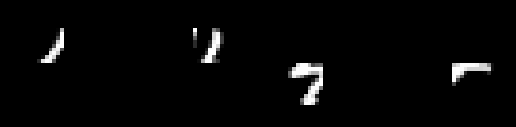

4
TL 0.1032
TR 0.1032
BL 0.1032
BR 0.1032
avg 0.1032
Iteration 50


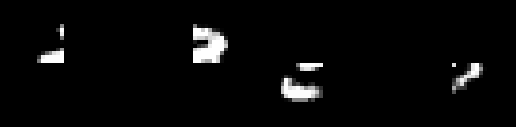

3
TL 0.1032
TR 0.1032
BL 0.1032
BR 0.1422
avg 0.1032


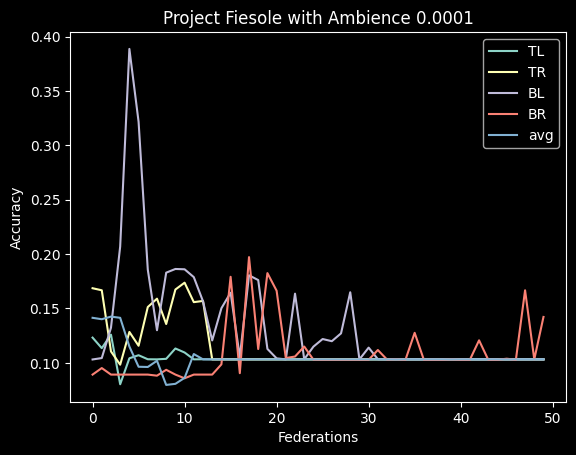

In [10]:
for i in range(ALL_HANDS_ON_DECK):
    print(f"Iteration {i+1}")
    model = federated_learning(model)

# Plot the results
plt.plot(tl_history, label="TL")
plt.plot(tr_history, label="TR")
plt.plot(bl_history, label="BL")
plt.plot(br_history, label="BR")
plt.plot(avg_history, label="avg")
plt.legend()
plt.xlabel("Federations")
plt.ylabel("Accuracy")
plt.title(f"Project Fiesole with Ambience {AMBIENT}")
import datetime

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
plt.savefig("fiesole-ambient-" + current_time + ".png")

plt.show()


torch.save(model.state_dict(), "fiesole.ckpt")
